Con questo Jupyter Notebook voglio mostrare come ho elaborato i dati CAMS relativi al PM10 di cui ho parlato in [questo articolo](https://massimilianomoraca.me/blog/gis/pm10-nord-italia/). I dati grezzi sono in formato NetCDF e di come gestire questo particolare formato dati ne ho parlato in un [altro articolo](https://massimilianomoraca.me/blog/pygis-blog/gestione-di-un-file-netcdf/) che, nemmeno a farlo apposta, è incentrato sui dati CAMS.

# Prima di iniziare

## Librerie

Le librerie Python usate per raggiungere lo scopo sono state diverse e le vedrete di seguito. Una però deve essere menzionata tra tutte [Dask](https://www.dask.org/); senza l'uso di questa librerie non mi sarebbe stato possibile velocizzare i processamenti che, nonostante tutto, sono durati ore.

In [16]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from geocube.api.core import make_geocube
from xrspatial.zonal import stats
import pandas as pd
import dask.dataframe as dd
import seaborn as sns


## Fonti dati

I dati del PM10 dal 2013 allo scorso marzo sono il perno di questa analisi a cui ho associato i dati vettoriali dell'ISTAT delle province target(quelle che ricadono nelle regioni con codice da 1 a 11) e sulla popolazione per cella censuaria. Dopo aver scaricato i dati CAMS li ho preprocessati in modo da avere un file `.nc` per anno.

In [2]:
nc_data_path = Path("/home/max/Desktop/pianura_padana/processed/netcdf")

nc_files = list(nc_data_path.glob("*.nc"))

nc_files

[PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2021-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2017-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2020-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2014-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2013-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2016-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2023-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2019-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2015-reanalyses.nc'),
 PosixPath('/home/max/Desktop/

In [3]:
target_zones_boundaries = Path("/home/max/Desktop/DEV/DrakoNotebook/open_dataset/Limiti01012023_g/ProvCM01012023_g/ProvCM01012023_g_WGS84.shp")

target_zones = gpd.read_file(target_zones_boundaries)
target_zones = target_zones[target_zones['COD_REG'].isin(list(range(1, 12)))]
# Nel prossimo passaggio effettuto una cambio di EPSG poichè i dati CAMS usano il 4326 mentre quelli ISTAT sono in 32632.
target_zones = target_zones.to_crs(4326).sort_values('DEN_UTS')

target_zones

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,Shape_Area,geometry
5,1,1,6,0,6,Alessandria,-,Alessandria,AL,Provincia,3.560310e+09,"POLYGON ((8.40549 45.20148, 8.41749 45.19846, ..."
41,3,11,42,0,42,Ancona,-,Ancona,AN,Provincia,1.961932e+09,"POLYGON ((13.21155 43.72501, 13.21979 43.71770..."
6,1,2,7,0,7,Aosta,-,Aosta,AO,Provincia,3.258838e+09,"POLYGON ((7.58857 45.97075, 7.58981 45.97073, ..."
50,3,9,51,0,51,Arezzo,-,Arezzo,AR,Provincia,3.233326e+09,"MULTIPOLYGON (((12.21800 43.60394, 12.21816 43..."
43,3,11,44,0,44,Ascoli Piceno,-,Ascoli Piceno,AP,Provincia,1.229268e+09,"POLYGON ((13.78663 43.07104, 13.79679 43.06211..."
...,...,...,...,...,...,...,...,...,...,...,...,...
26,2,5,27,227,227,-,Venezia,Venezia,VE,Citta metropolitana,2.473732e+09,"POLYGON ((12.79994 45.82573, 12.80158 45.82316..."
102,1,1,103,0,103,Verbano-Cusio-Ossola,-,Verbano-Cusio-Ossola,VB,Provincia,2.262145e+09,"POLYGON ((8.44976 46.46176, 8.46176 46.45081, ..."
1,1,1,2,0,2,Vercelli,-,Vercelli,VC,Provincia,2.082097e+09,"POLYGON ((8.20447 45.93567, 8.21365 45.92490, ..."
22,2,5,23,0,23,Verona,-,Verona,VR,Provincia,3.096255e+09,"POLYGON ((10.88379 45.77281, 10.88301 45.77202..."


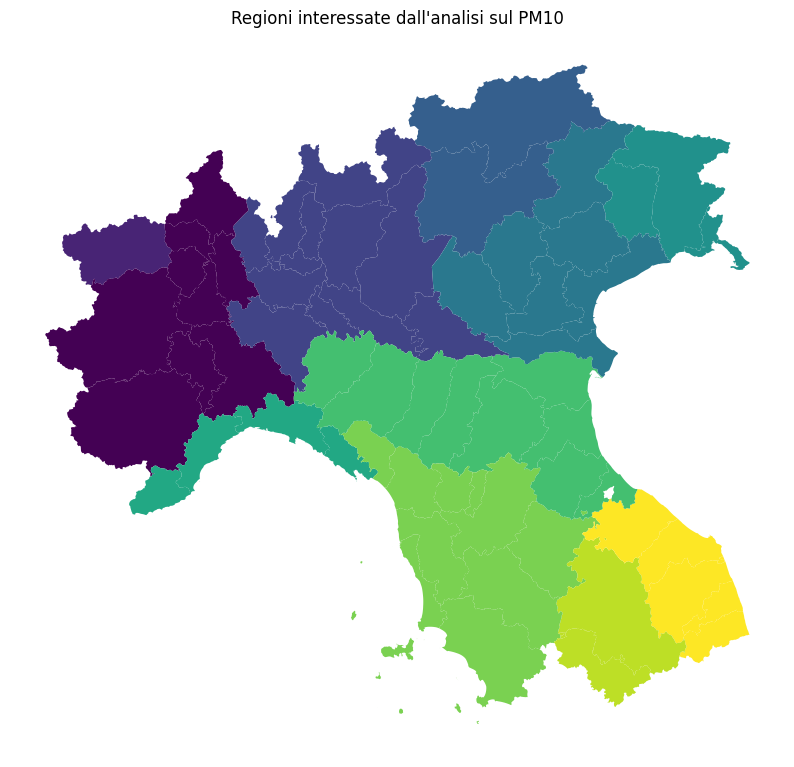

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))

target_zones.plot(
    ax=ax,
    column='COD_REG',
)
plt.title("Regioni interessate dall'analisi sul PM10")
plt.axis('off')
plt.show()

## Contenuti
- [Aggregazione dei dati](#Aggregazione-dei-dati)
- 
- [Conclusione](#Conclusione)

# Aggregazione dei dati

Lo scopo di questa attività è stato quello di aggregare i dati su base provinciale e di generare un `.csv` per Provincia. I tempi di calcolo sono davvero lunghi, notate la funzione `%%time` cosa stampa. 

In [5]:
csv_folder = Path("/home/max/Desktop/pianura_padana/processed/target_zones")

In [6]:
# %%time
# 
# # Analisi per Provincia
# for _index, _row in target_zones.iterrows():
#     zone_gdf = target_zones[target_zones['COD_PROV'] == _row['COD_PROV']]
#     
#     zone_data = []
#     
#     # Lettura dei singoli `.nc`
#     for file in nc_files:
#         year_data = xr.open_dataset(
#             filename_or_obj=file,
#             engine="netcdf4",
#             decode_coords="all",
#         )
#         
#         # Riordinamento delle coordinate per evitare problemi di dimensione
#         year_data = year_data.transpose('lat', 'lon', 'time')[['lat', 'lon', 'time', 'particulate_matter_10um']]
#         
#         time_coords = year_data['time'].values
#         
#         # Calcolo delle zonal statistic
#         for time in time_coords:
#             sensing_date = time.astype('datetime64[s]').item()
# 
#             time_data = year_data.sel(time=time).to_dataarray().squeeze()
#             
#             # Definizione delle dimensioni spaziali
#             time_data = time_data.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
#             
#             # Rasterizzazione del poligono della Provincia
#             rasterized_vector = make_geocube(
#                 vector_data=zone_gdf,
#                 measurements=['COD_PROV'],
#                 like=time_data,
#             )
#             vector_dataarray = rasterized_vector['COD_PROV']
#             
#             zonal_statistics = stats(
#                 zones=vector_dataarray,
#                 values=time_data,
#                 stats_funcs=["mean", "max", "min", "sum", "std", "count", "var"]
#             )
#             zonal_statistics.rename(columns={"zone": 'COD_PROV'}, inplace=True)
# 
#             zs_merged = pd.merge(
#                 left=zonal_statistics,
#                 right=zone_gdf,
#                 how='left',
#                 on='COD_PROV'
#             )
#             zs_merged = zs_merged[['COD_PROV', 'DEN_UTS', 'mean', 'max', 'min', 'sum', 'std', 'count', 'var']]
#             zs_merged['sensing_date'] = sensing_date
# 
#             zone_data.append(zs_merged)
#             #break
#         
#         
#         #break
#     # Aggregazione e generazione del csv
#     zone_ddf = dd.concat(zone_data)
#     zone_df = zone_ddf.compute()
# 
#     zone_df.to_csv(csv_folder.joinpath(f"zs_{_row['COD_PROV']}_{_row['DEN_UTS']}.csv"))
#     
#     
#     #break

CPU times: user 1d 5h 45min 22s, sys: 19min 52s, total: 1d 6h 5min 14s
Wall time: 1d 6h 2min 20s


![Alt text](./img/tempo_di_processamento.png "Tempo di processamento")

La configurazione dell'hardware che ho usato per questa analisi è quella di un **Dell XPS15 9530 con CPU i7-13700H, RAM 64GB DDR5, GPU NVIDIA GeForce RTX4050 con 6GB GDDR6**.

A questo punto possiamo creare il DataFrame con cui svilupperemo le nostre analisi.

In [13]:
%%time

dask_df = dd.read_csv(str(csv_folder / "*.csv"))

combined_ddf = dask_df.compute()
combined_ddf.drop(columns=['Unnamed: 0'], inplace=True)
combined_ddf['sensing_date'] = pd.to_datetime(combined_ddf['sensing_date'])
combined_ddf = combined_ddf[['DEN_UTS', 'sensing_date', 'min', 'max', 'mean', 'sum']]
combined_ddf.rename(columns={'DEN_UTS': 'Provincia'}, inplace=True)

combined_ddf.set_index(['Provincia', 'sensing_date'], inplace=True)
combined_ddf.sort_index(inplace=True, ascending=True)

combined_ddf

CPU times: user 14.8 s, sys: 1.16 s, total: 16 s
Wall time: 5.64 s


min        max       mean          sum
Provincia   sensing_date                                                     
Alessandria 2013-01-01 00:00:00  17.774128  73.087227  60.116840  2524.907227
            2013-01-01 01:00:00  34.121521  77.894402  67.446754  2832.763672
            2013-01-01 02:00:00  30.085140  77.120522  65.277397  2741.650635
            2013-01-01 03:00:00  28.961617  70.821129  57.437000  2412.354004
            2013-01-01 04:00:00  28.968790  60.781708  50.913219  2138.355225
...                                    ...        ...        ...          ...
Vicenza     2024-03-12 19:00:00   6.001117  44.228996  24.173279   725.198364
            2024-03-12 20:00:00   5.843284  51.150700  25.821503   774.645081
            2024-03-12 21:00:00   6.246823  50.693604  25.173981   755.219421
            2024-03-12 22:00:00   5.438911  56.303368  23.828772   714.863159
            2024-03-12 23:00:00   4.262040  58.259407  22.019205   660.576172

[6280704 rows x 4 columns]

# Conteggio degli sforamenti del limite normativo

In [14]:
%%time
# Calculate daily mean
target_stat_count = 'mean'
daily_mean = combined_ddf
daily_mean = daily_mean.groupby(['Provincia', pd.Grouper(level='sensing_date', freq='D')])[target_stat_count].mean()
daily_mean_df = pd.DataFrame(daily_mean)

# Count over limit
target_column_name = 'over_limit'

count_over_limit = daily_mean_df.loc[daily_mean_df[target_stat_count] >= 50].copy()
count_over_limit[target_column_name] = 1
count_over_limit.drop(columns=[target_stat_count], inplace=True)
count_over_limit = count_over_limit.groupby(['Provincia', pd.Grouper(level='sensing_date', freq='YE', dropna=False)])[target_column_name].sum()
over_limit_df = pd.DataFrame(count_over_limit)

over_limit_df

CPU times: user 841 ms, sys: 244 ms, total: 1.08 s
Wall time: 1.08 s


over_limit
Provincia   sensing_date            
Alessandria 2013-12-31             8
            2014-12-31             5
            2015-12-31             9
            2016-12-31            13
            2017-12-31             3
...                              ...
Vicenza     2020-12-31            13
            2021-12-31            15
            2022-12-31            17
            2023-12-31            27
            2024-12-31            21

[462 rows x 1 columns]

In [15]:
%%time
pivot_over_limit_df = over_limit_df.pivot_table(index='Provincia', columns='sensing_date', values=target_column_name)
pivot_over_limit_df.fillna(0, inplace=True)

pivot_over_limit_df

CPU times: user 8.67 ms, sys: 0 ns, total: 8.67 ms
Wall time: 7.99 ms


sensing_date,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31,2023-12-31,2024-12-31
Provincia,,,,,,,,,,,,
Alessandria,8.0,5.0,9.0,13.0,3.0,2.0,9.0,0.0,6.0,1.0,2.0,8.0
Ancona,0.0,1.0,2.0,1.0,0.0,0.0,0.0,3.0,7.0,1.0,0.0,0.0
Aosta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
Arezzo,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,3.0,1.0,0.0,0.0
Ascoli Piceno,0.0,4.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Venezia,15.0,12.0,39.0,21.0,20.0,6.0,17.0,25.0,17.0,25.0,32.0,24.0
Verbano-Cusio-Ossola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
Vercelli,3.0,1.0,4.0,0.0,2.0,0.0,4.0,0.0,5.0,2.0,0.0,3.0


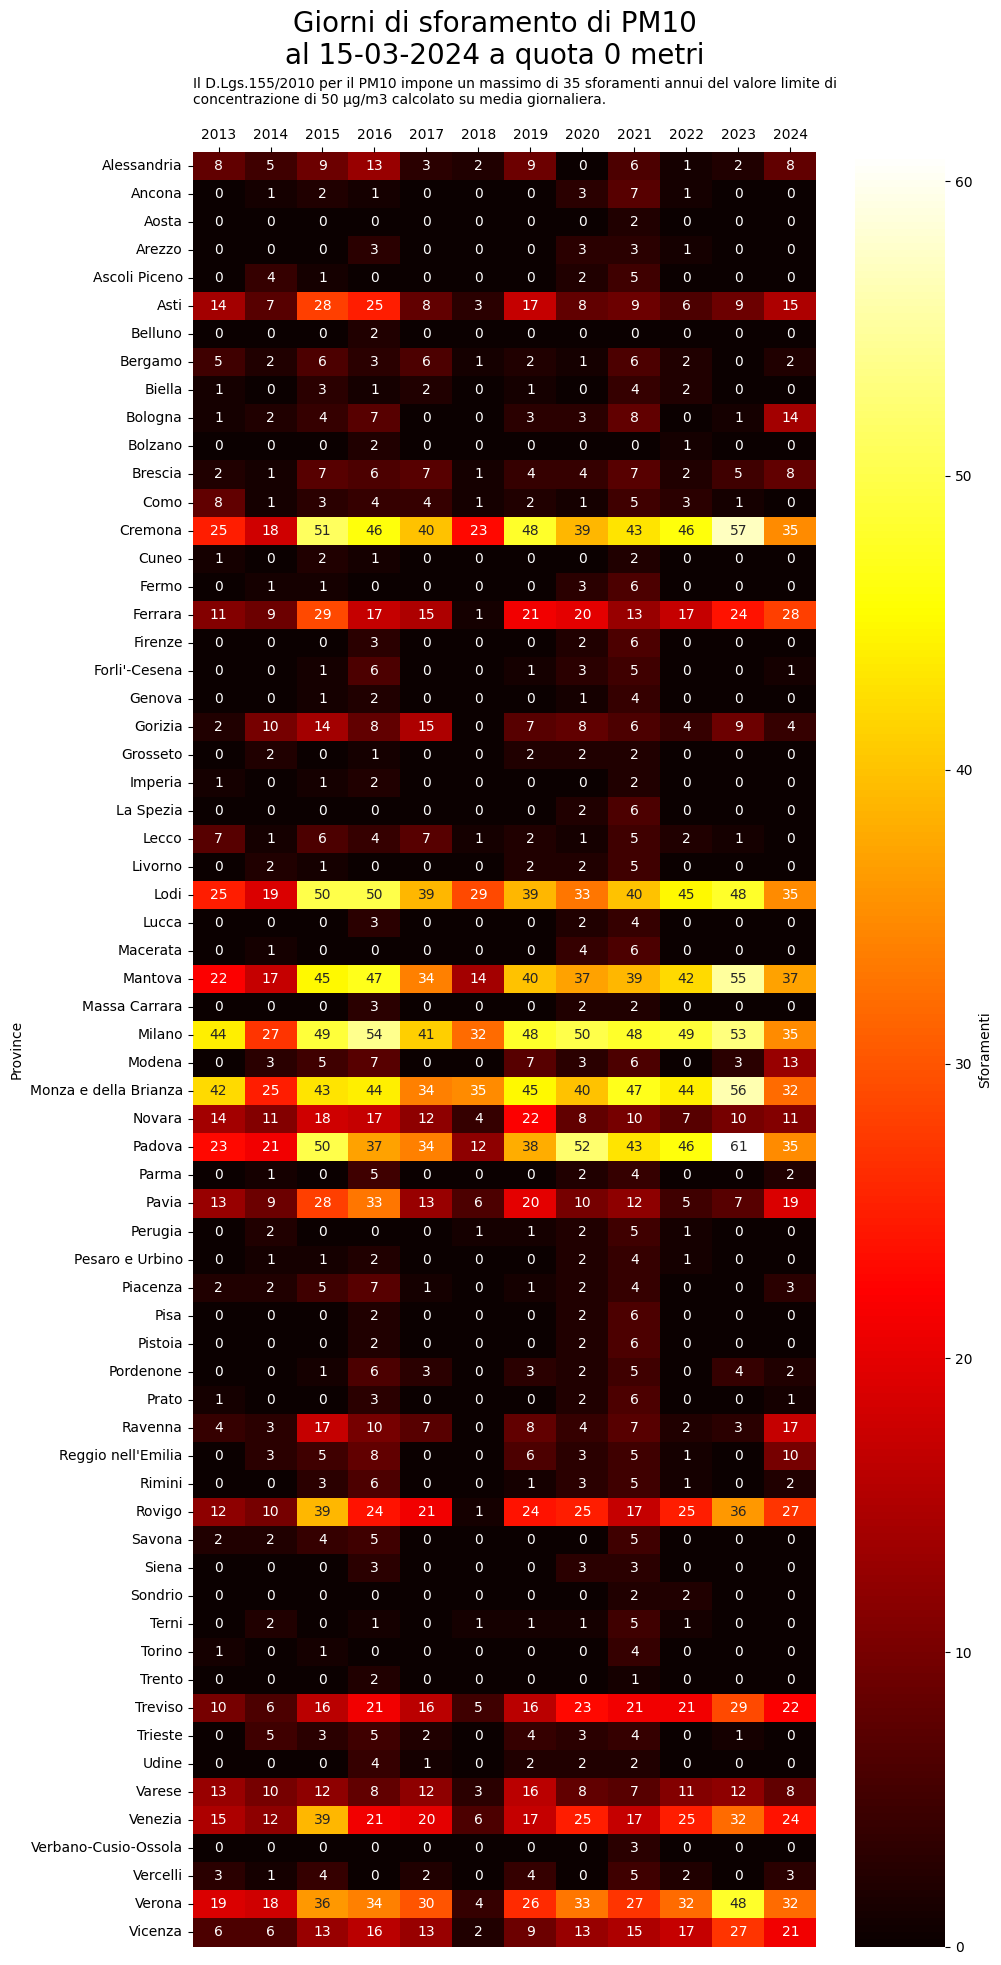

In [19]:
# Create a figure with two subplots
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 20))
fig1.suptitle('Giorni di sforamento di PM10\nal 15-03-2024 a quota 0 metri', fontsize=20)

# Plot the heatmap on the first subplot
sns.heatmap(pivot_over_limit_df, cmap="hot", ax=ax1, annot=True)

description = ("\nIl D.Lgs.155/2010 per il PM10 impone un massimo di 35 sforamenti annui del valore limite di\n"
               "concentrazione di 50 µg/m3 calcolato su media giornaliera.\n")
ax1.set_title(description, loc='left', fontsize=10)
ax1.set_xlabel('')
ax1.set_ylabel('Province')
ax1.xaxis.tick_top()

# Get the current tick labels and format them to display only the date
labels1= [item.get_text()[:4] for item in ax1.get_xticklabels()]
ax1.set_xticklabels(labels1)

# Rotate x-axis labels to 45 degrees
ax1.tick_params(axis='x', rotation=0)

# Add color bar on the first subplot
cbar1 = ax1.collections[0].colorbar
cbar1.set_label('Sforamenti')

# Adjust layout
plt.tight_layout()

plt.show()

# Cumulo di PM10 annuale

In [20]:
%%time
# Calculate daily mean
yearly_mean = combined_ddf
yearly_mean = yearly_mean.groupby(['Provincia', pd.Grouper(level='sensing_date', freq='YE')])['sum'].sum()
yearly_mean_df = pd.DataFrame(yearly_mean)
# from µg/m3 to g/m3
yearly_mean_df['sum'] *= 0.000001
yearly_mean_df['sum'] = yearly_mean_df['sum'].round(0)

yearly_mean_df

CPU times: user 826 ms, sys: 216 ms, total: 1.04 s
Wall time: 1.04 s


sum
Provincia   sensing_date     
Alessandria 2013-12-31    8.0
            2014-12-31    6.0
            2015-12-31    8.0
            2016-12-31    8.0
            2017-12-31    7.0
...                       ...
Vicenza     2020-12-31    6.0
            2021-12-31    6.0
            2022-12-31    6.0
            2023-12-31    6.0
            2024-12-31    2.0

[768 rows x 1 columns]

In [21]:
%%time
pivot_yearly = yearly_mean_df.pivot_table(index='Provincia', columns='sensing_date', values='sum')
pivot_yearly.fillna(0, inplace=True)

pivot_yearly

CPU times: user 1.22 ms, sys: 3.92 ms, total: 5.15 ms
Wall time: 4.93 ms


sensing_date,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31,2023-12-31,2024-12-31
Provincia,,,,,,,,,,,,
Alessandria,8.0,6.0,8.0,8.0,7.0,7.0,7.0,6.0,6.0,7.0,6.0,2.0
Ancona,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0
Aosta,4.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,0.0
Arezzo,5.0,5.0,6.0,6.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,1.0
Ascoli Piceno,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Venezia,5.0,5.0,6.0,6.0,5.0,5.0,5.0,5.0,5.0,6.0,6.0,2.0
Verbano-Cusio-Ossola,3.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
Vercelli,4.0,3.0,5.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,1.0


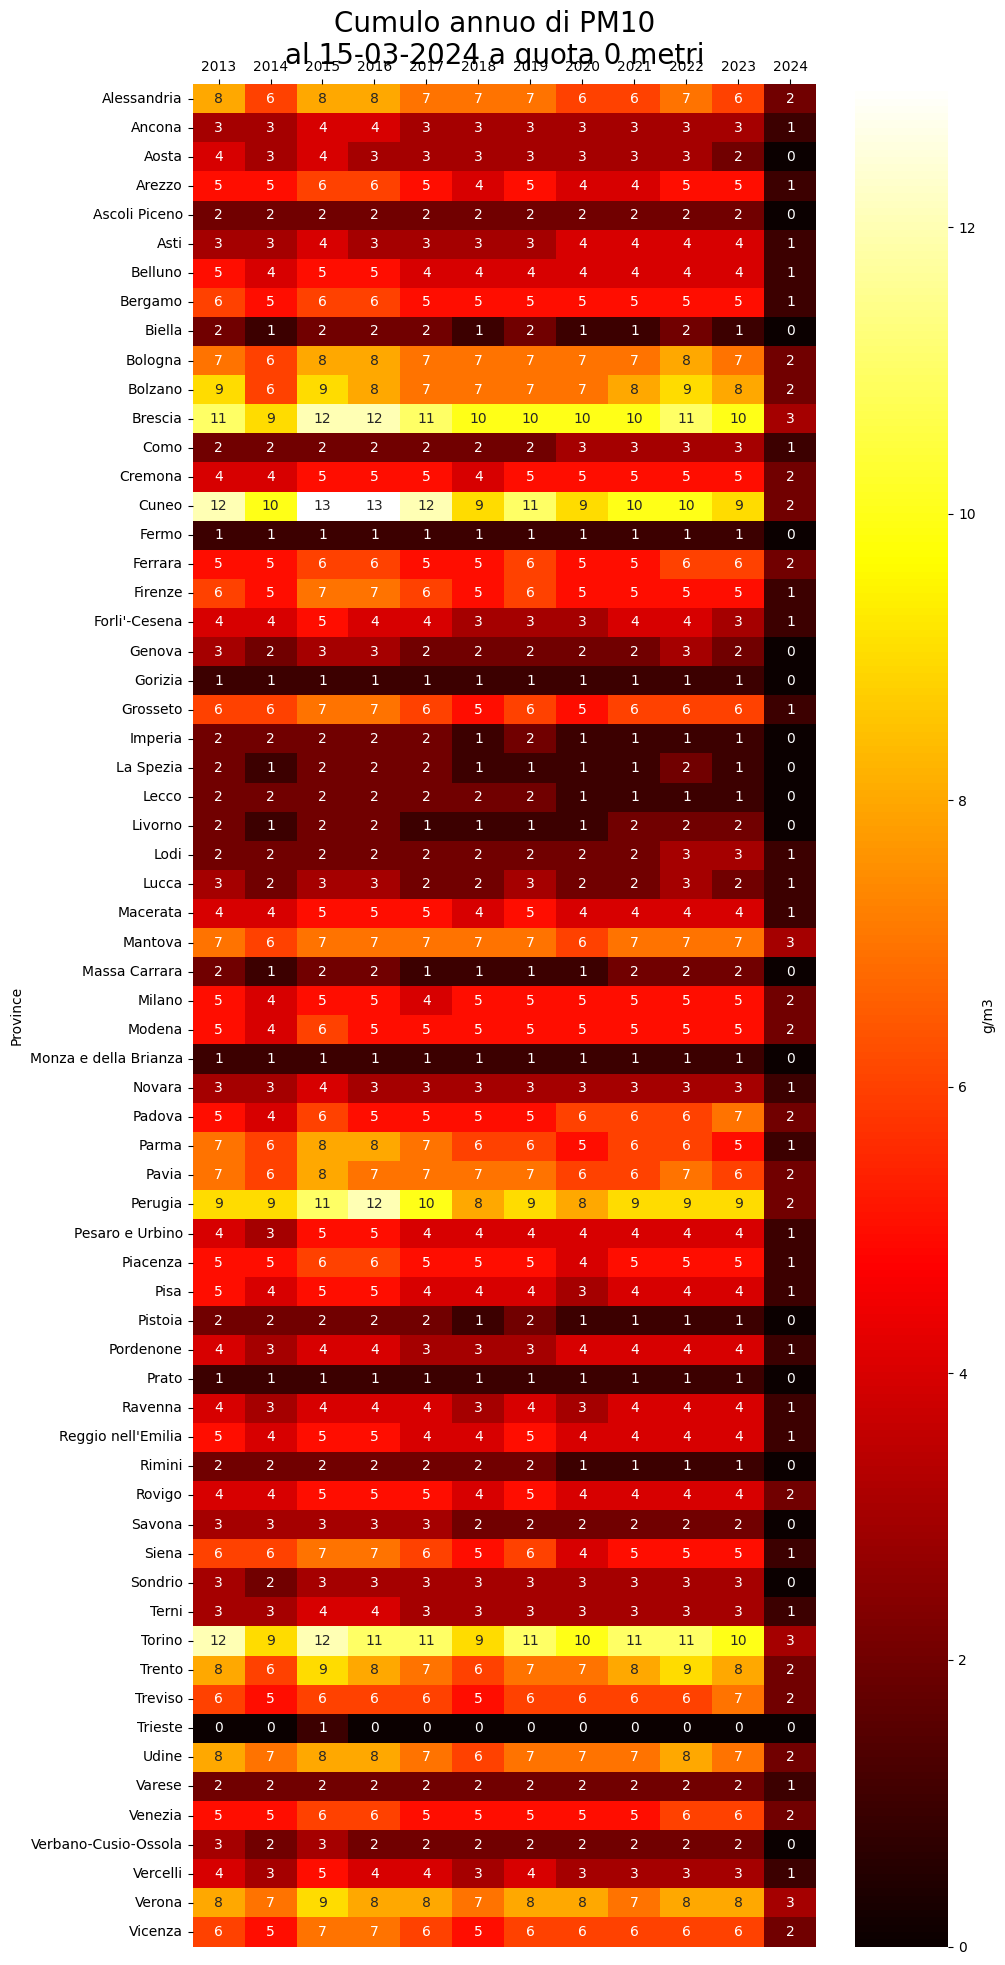

In [23]:
# Create a figure with two subplots
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(10, 20))
fig2.suptitle('Cumulo annuo di PM10\nal 15-03-2024 a quota 0 metri', fontsize=20)

# Plot the heatmap on the first subplot
sns.heatmap(pivot_yearly, cmap="hot", ax=ax2, annot=True)

ax2.set_xlabel('')
ax2.set_ylabel('Province')
ax2.xaxis.tick_top()

# Get the current tick labels and format them to display only the date
labels2 = [item.get_text()[:4] for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labels2)

# Rotate x-axis labels to 45 degrees
ax2.tick_params(axis='x', rotation=0)

# Add color bar on the first subplot
cbar2 = ax2.collections[0].colorbar
cbar2.set_label('g/m3')

# Adjust layout
plt.tight_layout()

plt.show()